In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

### Функции

In [2]:
def plot_ecdf(data):
    x, y = sorted(data), np.arange(1, len(data)+1) / len(data)
    plt.figure()
    plt.scatter(x, y)
    plt.grid()
    plt.show()
    
    
def make_strats(df):
    df['age_bins'] = None
    df.loc[(df['age'] <= 20) | (df['age'] > 40), 'age_bins'] = 1
    df.loc[(df['age'] > 20) & (df['age'] <= 25), 'age_bins'] = 2
    df.loc[(df['age'] > 25) & (df['age'] <= 35), 'age_bins'] = 3
    df.loc[(df['age'] > 35) & (df['age'] <= 40), 'age_bins'] = 2

    df['strat'] = df.groupby(['age_bins', 'gender']).ngroup()
    return df.drop(columns=['age_bins'])

### Загрузка данных

In [3]:
users = pd.read_csv('data/df_users.csv')
sales = pd.read_csv('data/df_sales.csv')

Вам доступны два файла (срез данных, аналогичный тем, что будут в боевом задании, но на несколько порядков меньше в своем размере), на которых вы можете проверить работоспособность своего кода

> `users`, который может быть получен с помощью команды <br>
> ```df_users = pd.read_csv(os.environ['PATH_DF_USERS'])```

> `sales`, который может быть получен с помощью команды <br>
> ```df_sales = pd.read_csv(os.environ['PATH_DF_SALES'])```

Давайте рассмотрим их отдельно

> Файл `users` хранит в себе информацию о пользователях. В файле присутствет три колонки

> `user_id` – идентификатор пользователя <br>
> `gender` – пол пользователя <br>
> `age` – возраст пользователя

> Например, пользователь с идентификатором `2481878` имеет пол `0`, причем ему `26` лет. Все пользователи в таблице уникальны

In [4]:
users.head(3)

,user_id,gender,age
0,2661066,0,22
1,3848565,1,29
2,5801450,0,24


> Файл `sales` хранит информацию о покупках пользователей. В файле `sales` присутствет три колонки

> `user_id` – идентификатор пользователя <br>
> `day` – день, в который была совершена покупка пользователя <br>
> `sales` – сумма транзакции, которую совершил пользователь `user_id` в `day`

> Например, пользователь с идентификатором `4137940` в день `39` совершил покупку на `276` рублей

In [5]:
sales.head(3)

,user_id,day,sales
0,2661066,0,397
1,3848565,1,841
2,3848565,2,423


> файлы `users` и `sales` имеют общий ключ `user_id`

### Изучим данные

### Клиенты

In [6]:
users.gender.value_counts()

0    570197
1    429803
Name: gender, dtype: int64

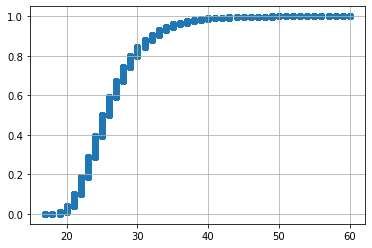

In [7]:
plot_ecdf(users.age.values)

### Продажи

In [8]:
sales['week_num'] = np.floor(sales.day / 7)

In [9]:
mask_test = sales['week_num'].isin([7])

In [10]:
user_rev = sales.groupby(['user_id', 'week_num'])['sales'].sum().reset_index()
user_rev_test = sales[mask_test].groupby('user_id')['sales'].sum().reset_index()

In [11]:
user_rev.week_num.value_counts()

4.0    878893
2.0    878720
6.0    878326
0.0    875419
3.0    863895
1.0    863244
5.0    863226
7.0    862269
Name: week_num, dtype: int64

0.0


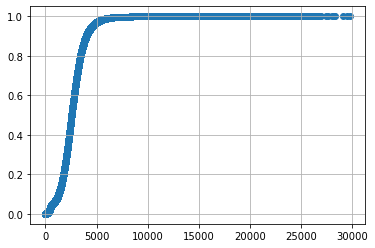

1.0


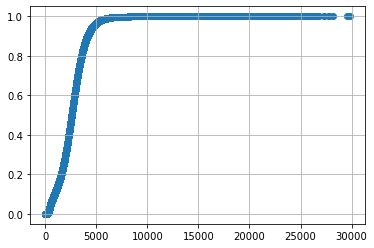

2.0


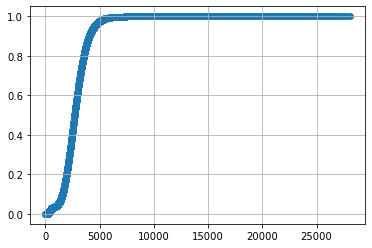

3.0


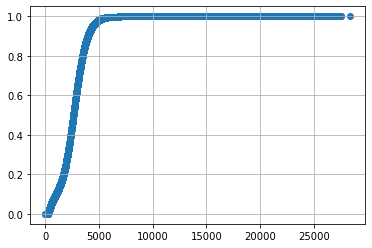

4.0


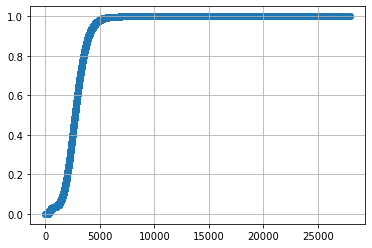

5.0


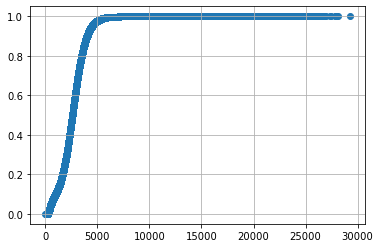

6.0


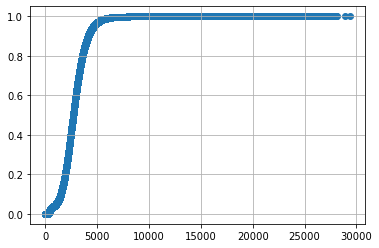

7.0


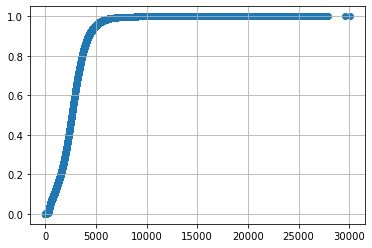

In [12]:
for week_num in user_rev.week_num.unique():
    print(week_num)
    plot_ecdf(user_rev[user_rev.week_num == week_num].sales.values)

In [13]:
mask_inliers = (sales.sales <= np.quantile(user_rev[user_rev.week_num < 7].sales.values, .99))

### Cтраты

In [14]:
users = make_strats(users)
weights = (users['strat'].value_counts() / users.shape[0]).to_dict()

In [15]:
df_pilot = (
    sales
    .loc[mask_test & mask_inliers]
    .groupby('user_id')['sales']
    .sum()
    .reset_index()
    .merge(users)
)

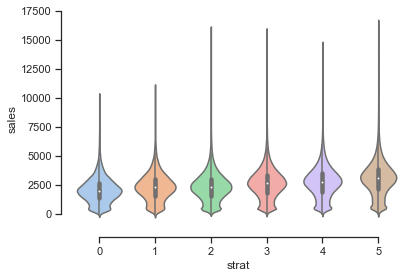

In [16]:
sns.set_theme(style='ticks', palette='pastel')

sns.violinplot(x='strat', y='sales',
            data=df_pilot)

sns.despine(offset=10, trim=True)